In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    poutres_path = os.path.join(base_dir, f"maquette{i}", f"poutres{i}.csv")
    if os.path.exists(poutres_path):
        with open(poutres_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(poutres_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {poutres_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {poutres_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {poutres_path}")

if dfs:
    poutres_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {poutres_concat.shape[0]} lignes, {poutres_concat.shape[1]} colonnes")
else:
    poutres_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

poutres_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/poutres1.csv (778 lignes, 136 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  822465        GO        POUTRE          INTERIEUR         PREFA CHANTIER   
1  822610        GO        POUTRE          INTERIEUR         PREFA CHANTIER   
2  823043        GO   BANDE NOYEE            COURANT         COULE EN PLACE   
3  823110        GO   BANDE NOYEE            COURANT         COULE EN PLACE   
4  823289        GO   BANDE NOYEE            COURANT         COULE EN PLACE   

       Nom                  AI                 AS Hauteur totale  \
0  30x60ht  -0,200000000000001  0,200000000000001            0,6   
1  25x50ht  -0,150000000000001  0,150000000000001            0,5   
2  30x20ht                -0,1                0,1            0,2   
3  30x20ht                -0,1                0,1            0,2   
4  30x20ht                -0,1                0,1            0,2   

  

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,AI,AS,Hauteur totale,Hauteur,...,Largeur du noyau,Décalage d'alvéole,Nombre d'alvéoles,Hauteur du noyau,D2,D3,D4,D5,Retombé,Hauteur Poutre
0,822465,GO,POUTRE,INTERIEUR,PREFA CHANTIER,30x60ht,"-0,200000000000001","0,200000000000001","0,6","0,400000000000002",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822610,GO,POUTRE,INTERIEUR,PREFA CHANTIER,25x50ht,"-0,150000000000001","0,150000000000001","0,5","0,300000000000002",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,823043,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,823110,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,823289,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
poutres_concat.shape

(20727, 529)

In [4]:
print(poutres_concat)

            Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation  \
0       822465        GO        POUTRE          INTERIEUR   
1       822610        GO        POUTRE          INTERIEUR   
2       823043        GO   BANDE NOYEE            COURANT   
3       823110        GO   BANDE NOYEE            COURANT   
4       823289        GO   BANDE NOYEE            COURANT   
...        ...       ...           ...                ...   
20722  4543660        GO   BANDE NOYEE            COURANT   
20723  4546571        GO   BANDE NOYEE            COURANT   
20724  4546572        GO   BANDE NOYEE            COURANT   
20725  4548917        GO        POUTRE            COURANT   
20726  4549419        GO        POUTRE            COURANT   

      014EC_Mode Constructif                   Nom                  AI  \
0             PREFA CHANTIER               30x60ht  -0,200000000000001   
1             PREFA CHANTIER               25x50ht  -0,150000000000001   
2             COULE EN PLACE               30

In [5]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom"
]

# On ne garde que les colonnes présentes dans le DataFrame
poutres_concat = poutres_concat[[col for col in colonnes_a_garder if col in poutres_concat.columns]]

In [6]:
print(poutres_concat.columns.tolist())

['011EC_Lot', '012EC_Ouvrage', '013EC_Localisation', '014EC_Mode Constructif', 'Sols en intersection', 'Sols coupés (u)', 'Sols coupants (u)', 'Sol au-dessus', 'Sol en-dessous', 'Matériau structurel', 'Famille et type', 'Nom']


In [7]:
poutres_concat

,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Sols en intersection,Sols coupés (u),Sols coupants (u),Sol au-dessus,Sol en-dessous,Matériau structurel,Famille et type,Nom
0,GO,POUTRE,INTERIEUR,PREFA CHANTIER,0,0,1,False,False,Béton - Béton précoulé,Poutre rectangulaire: 30x60ht,30x60ht
1,GO,POUTRE,INTERIEUR,PREFA CHANTIER,0,0,1,False,False,Béton - Béton précoulé,Poutre rectangulaire: 25x50ht,25x50ht
2,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,1,0,False,False,Béton - Béton précoulé,Bande noyée: 30x20ht,30x20ht
3,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,1,0,False,False,Béton - Béton précoulé,Bande noyée: 30x20ht,30x20ht
4,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,1,0,False,False,Béton - Béton précoulé,Bande noyée: 30x20ht,30x20ht
...,...,...,...,...,...,...,...,...,...,...,...,...
20722,GO,BANDE NOYEE,COURANT,COULE EN PLACE,1,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_BN10_30x27,ECDA_RDC_BN10_30x27
20723,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_BN2_30x27,ECDA_RDC_BN2_30x27
20724,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_BN2_30x27,ECDA_RDC_BN2_30x27
20725,GO,POUTRE,COURANT,PREFA CHANTIER,1,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_PO_08_40x65,ECDA_RDC_PO_08_40x65


In [8]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

poutres_concat.columns = [clean_col(c) for c in poutres_concat.columns]
print(poutres_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'materiau_structurel', 'famille_et_type', 'nom']


In [9]:
import joblib

# Définir les targets multi-label (adapte la liste selon tes besoins)
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in poutres_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans murs_concat. Colonnes disponibles : {poutres_concat.columns.tolist()}")

# X et y_multi
X = poutres_concat.drop(columns=targets_in_df)
y_multi = poutres_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(RandomForestClassifier(n_estimators=5000, random_state=42)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)

# Sauvegarde du pipeline complet
joblib.dump(pipeline, 'randomforestpoutrespipeline.pkl')

print("Pipeline complet sauvegardé dans bimpredict_pipeline.pkl")

# Prédiction et score baseline
y_pred = pipeline.predict(X_test)
print("Accuracy moyenne multi-label :", (y_pred == y_test.values).mean())

Pipeline complet sauvegardé dans bimpredict_pipeline.pkl
Accuracy moyenne multi-label : 0.968463462072798


In [10]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sols_en_intersection',
                                                   'sols_coupes_u',
                                                   'sols_coupants_u']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['materiau_structurel',
                                                   'famille_et_type',
                                                   'nom'])])),
                ('model',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=5000,
                                                                        random_state=42)))])

In [11]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 3599 échantillons.


In [12]:
y_multi


,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,POUTRE,INTERIEUR,PREFA CHANTIER
1,GO,POUTRE,INTERIEUR,PREFA CHANTIER
2,GO,BANDE NOYEE,COURANT,COULE EN PLACE
3,GO,BANDE NOYEE,COURANT,COULE EN PLACE
4,GO,BANDE NOYEE,COURANT,COULE EN PLACE
...,...,...,...,...
20722,GO,BANDE NOYEE,COURANT,COULE EN PLACE
20723,GO,BANDE NOYEE,COURANT,COULE EN PLACE
20724,GO,BANDE NOYEE,COURANT,COULE EN PLACE
20725,GO,POUTRE,COURANT,PREFA CHANTIER


In [13]:
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9685
F1 macro (moyenne par cible): 0.9340


In [14]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
2      013ec_localisation  0.798070
3  014ec_mode_constructif  0.959496
1           012ec_ouvrage  0.978298
0               011ec_lot  1.000000


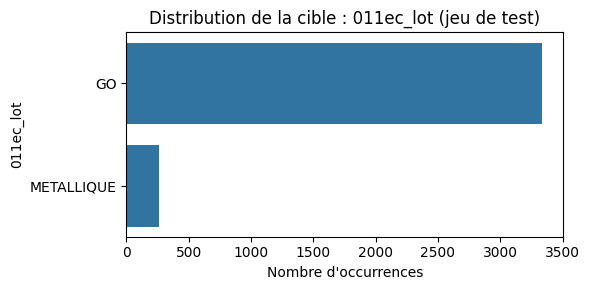

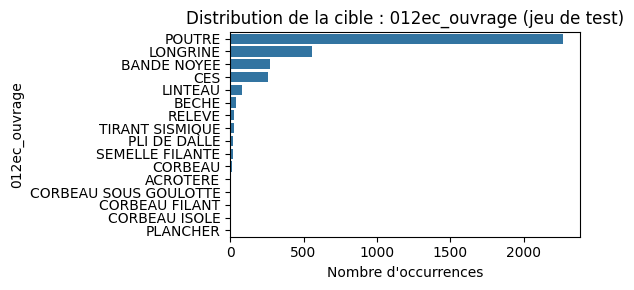

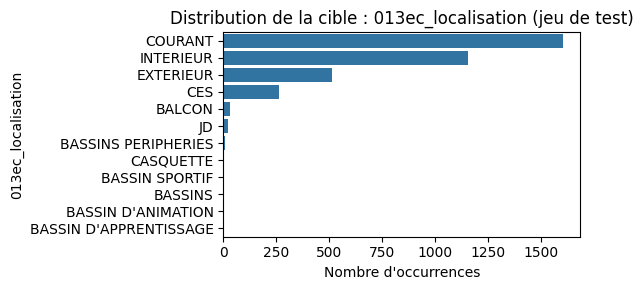

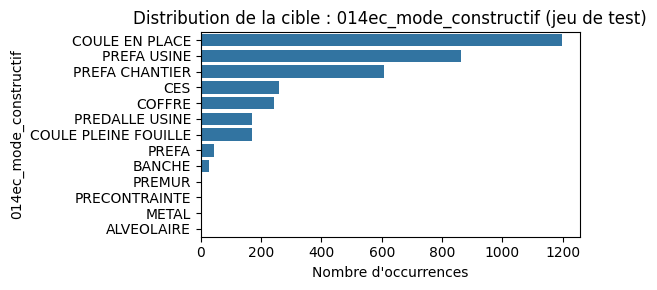

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

# Afficher la distribution de chaque cible sur y_test
for col in y_test.columns:
    plt.figure(figsize=(6, 3))
    sns.countplot(y=y_test[col], order=y_test[col].value_counts().index)
    plt.title(f"Distribution de la cible : {col} (jeu de test)")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel(col)
    plt.tight_layout()

In [16]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===
              precision    recall  f1-score   support

          GO       1.00      1.00      1.00      3339
  METALLIQUE       1.00      1.00      1.00       260

    accuracy                           1.00      3599
   macro avg       1.00      1.00      1.00      3599
weighted avg       1.00      1.00      1.00      3599

=== Classification Report for 012ec_ouvrage ===
                       precision    recall  f1-score   support

             ACROTERE       1.00      1.00      1.00         5
          BANDE NOYEE       1.00      0.97      0.98       274
                BECHE       1.00      1.00      1.00        39
                  CES       1.00      1.00      1.00       260
              CORBEAU       1.00      0.92      0.96        13
       CORBEAU FILANT       1.00      1.00      1.00         2
        CORBEAU ISOLE       1.00      1.00      1.00         1
CORBEAU SOUS GOULOTTE       1.00      1.00      1.00         2
             

                                                Feature  Importance
6           materiau_structurel_Acier structurel - S275    0.113350
2                                       sols_coupants_u    0.054349
562                 famille_et_type_HE-A_projet: HEA200    0.048301
1703                                         nom_HEA200    0.048171
2010                                            nom_U80    0.032950
1009                             famille_et_type_U: U80    0.032863
15               materiau_structurel_C25/30 - longrines    0.017346
17     materiau_structurel_Concrete, Cast-in-Place gray    0.016119
16                 materiau_structurel_C25/30 - poutres    0.014951
24        materiau_structurel_GOE-Béton Coulé sur Place    0.012901
563                 famille_et_type_HE-A_projet: HEA300    0.012189
1993                            nom_Poutre Parametrable    0.011955
4                   materiau_structurel_<Par catégorie>    0.011755
1704                                         nom

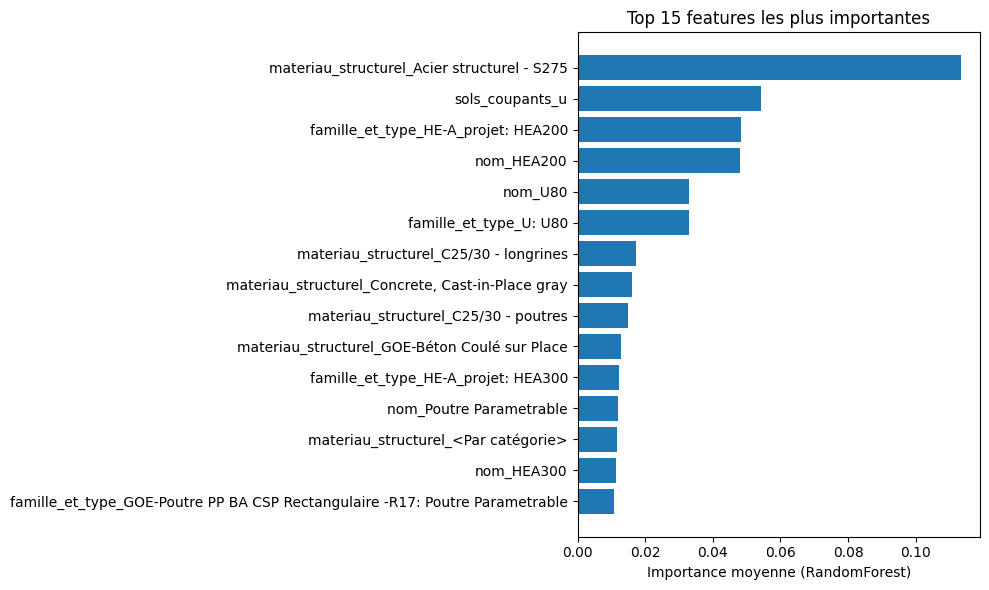

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# S'assurer que feature_names et importances ont la même longueur
if len(feature_names) != len(importances):
    min_len = min(len(feature_names), len(importances))
    print(f"Attention: feature_names ({len(feature_names)}) et importances ({len(importances)}) n'ont pas la même longueur. Troncature à {min_len}.")
    feature_names = feature_names[:min_len]
    importances = importances[:min_len]

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Afficher les 15 features les plus importantes
print(feat_imp.head(15))

# Visualisation
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel("Importance moyenne (RandomForest)")
plt.title("Top 15 features les plus importantes")
plt.tight_layout()
plt.show()

In [18]:
y_pred[:, 0]

array(['GO', 'GO', 'GO', ..., 'GO', 'GO', 'GO'], dtype=object)

In [19]:
y_test.iloc[:, 0]

6867     GO
20024    GO
8247     GO
20226    GO
1346     GO
         ..
11433    GO
5472     GO
1213     GO
12681    GO
14728    GO
Name: 011ec_lot, Length: 3599, dtype: object

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

In [21]:
y_pred_df['011ec_lot'].value_counts()


GO            3339
METALLIQUE     260
Name: 011ec_lot, dtype: int64

In [22]:
# Charger le CSV
csv_path = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/datatest/test5/test5full/poutres5.csv"
if not os.path.isfile(csv_path):
    print(f"Le fichier n'existe pas : {csv_path}")
    df_test = None
else:
    df_test = pd.read_csv(csv_path, delimiter=';', header=1)

In [23]:
df_test.shape

(267, 153)

In [24]:
df_test.columns

Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'AI', 'AS', 'Hauteur totale',
       'Hauteur',
       ...
       'Plan de construction', 'Type d'attachement de début',
       'Valeur de décalage de l'extrémité Z', 'Justification de l'extrémité Z',
       'Valeur de décalage de l'extrémité Y', 'Justification de l'extrémité Y',
       'Valeur de décalage Z de début', 'Justification Z de début',
       'Valeur de décalage Y de début', 'Justification Y de début'],
      dtype='object', length=153)

In [25]:
df_test['013EC_Localisation'].value_counts()

INTERIEUR    153
COURANT      109
EXTERIEUR      4
Name: 013EC_Localisation, dtype: int64

In [26]:
df_test.head(50)

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,AI,AS,Hauteur totale,Hauteur,...,Plan de construction,Type d'attachement de début,Valeur de décalage de l'extrémité Z,Justification de l'extrémité Z,Valeur de décalage de l'extrémité Y,Justification de l'extrémité Y,Valeur de décalage Z de début,Justification Z de début,Valeur de décalage Y de début,Justification Y de début
0,7265610,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7266837,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7267066,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,500000000000001",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7267079,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7267139,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7267519,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7267678,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7267893,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7267906,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7267921,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,LG 70x50ht,"7,40000000000026","7,90000000000026","0,499999999999999","0,499999999999999",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom",
]

# On ne garde que les colonnes présentes dans le DataFrame
df_test = df_test[[col for col in colonnes_a_garder if col in df_test.columns]]

In [28]:
def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

df_test.columns = [clean_col(c) for c in df_test.columns]
print(df_test.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'materiau_structurel', 'famille_et_type', 'nom']


In [29]:
df_test.head()

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,materiau_structurel,famille_et_type,nom
0,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
1,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
2,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
3,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
4,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht


In [30]:
targets_test = df_test.columns[:4]

In [31]:
targets_test

Index(['011ec_lot', '012ec_ouvrage', '013ec_localisation',
       '014ec_mode_constructif'],
      dtype='object')

In [32]:
df_test.isna().sum()

011ec_lot                 0
012ec_ouvrage             1
013ec_localisation        1
014ec_mode_constructif    1
sols_en_intersection      0
sols_coupes_u             0
sols_coupants_u           0
sol_au_dessus             0
sol_en_dessous            0
materiau_structurel       0
famille_et_type           0
nom                       0
dtype: int64

In [33]:
X_test_new = df_test

In [34]:
targets_test

Index(['011ec_lot', '012ec_ouvrage', '013ec_localisation',
       '014ec_mode_constructif'],
      dtype='object')

In [35]:
y_test_new = df_test[targets_test]

In [36]:
df_test

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,materiau_structurel,famille_et_type,nom
0,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
1,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
2,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
3,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
4,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
...,...,...,...,...,...,...,...,...,...,...,...,...
262,GO,LONGRINE,INTERIEUR,COFFRE,0,0,0,False,False,Béton,Poutre Rectangulaire: LG 70x50ht,LG 70x50ht
263,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,0,1,0,False,False,Béton,Poutre Rectangulaire: LG 70x80ht,LG 70x80ht
264,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,0,0,0,False,False,Béton,Poutre Rectangulaire: LG 50x25ht,LG 50x25ht
265,GO,LONGRINE,INTERIEUR,PREFA CHANTIER,1,0,0,False,False,Béton,Poutre Rectangulaire: LG 60x60ht,LG 60x60ht


In [37]:
if X_test_new.shape[0] == 0:
	print("Aucune donnée à prédire : X_test_new est vide.")
	y_pred = None
else:
	y_pred = pipeline.predict(X_test_new)

In [38]:
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

In [39]:
y_pred_df['011ec_lot']

0      GO
1      GO
2      GO
3      GO
4      GO
       ..
262    GO
263    GO
264    GO
265    GO
266    GO
Name: 011ec_lot, Length: 267, dtype: object

In [40]:
y_test_new

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
1,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
2,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
3,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
4,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
...,...,...,...,...
262,GO,LONGRINE,INTERIEUR,COFFRE
263,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
264,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
265,GO,LONGRINE,INTERIEUR,PREFA CHANTIER


In [ ]:
print(y_test_new['014ec_mode_constructif'].value_counts())
print(y_pred_df['014ec_mode_constructif'].value_counts())

INTERIEUR    153
COURANT      109
EXTERIEUR      4
Name: 013ec_localisation, dtype: int64
COURANT      240
INTERIEUR     27
Name: 013ec_localisation, dtype: int64


In [42]:
y_pred_df['013ec_localisation'] = y_pred_df['013ec_localisation'].astype(str)
y_test_new['013ec_localisation'] = y_test_new['013ec_localisation'].astype(str)

/var/folders/x6/j7yc7yjj3xd1bjpj4469g9880000gn/T/ipykernel_26347/3271759861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_new['013ec_localisation'] = y_test_new['013ec_localisation'].astype(str)


In [43]:
y_test_new.head(50)

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
1,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
2,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
3,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
4,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
5,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
6,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
7,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
8,GO,LONGRINE,INTERIEUR,PREFA CHANTIER
9,GO,LONGRINE,INTERIEUR,PREFA CHANTIER


In [44]:
y_pred_df.head(50)

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,POUTRE,COURANT,COULE EN PLACE
1,GO,POUTRE,COURANT,COULE EN PLACE
2,GO,POUTRE,COURANT,COULE EN PLACE
3,GO,POUTRE,COURANT,COULE EN PLACE
4,GO,POUTRE,COURANT,COULE EN PLACE
5,GO,POUTRE,COURANT,COULE EN PLACE
6,GO,POUTRE,COURANT,COULE EN PLACE
7,GO,POUTRE,COURANT,COULE EN PLACE
8,GO,POUTRE,COURANT,COULE EN PLACE
9,GO,POUTRE,COURANT,COULE EN PLACE


In [45]:
print(y_test_new['012ec_ouvrage'].value_counts())
y_pred_df['012ec_ouvrage'].value_counts()

BANDE NOYEE             109
POUTRE                   79
LONGRINE                 51
LINTEAU                  23
MASSIF TETE DE PIEUX      4
Name: 012ec_ouvrage, dtype: int64


POUTRE    267
Name: 012ec_ouvrage, dtype: int64

In [46]:
y_pred_df.head(50)

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,POUTRE,COURANT,COULE EN PLACE
1,GO,POUTRE,COURANT,COULE EN PLACE
2,GO,POUTRE,COURANT,COULE EN PLACE
3,GO,POUTRE,COURANT,COULE EN PLACE
4,GO,POUTRE,COURANT,COULE EN PLACE
5,GO,POUTRE,COURANT,COULE EN PLACE
6,GO,POUTRE,COURANT,COULE EN PLACE
7,GO,POUTRE,COURANT,COULE EN PLACE
8,GO,POUTRE,COURANT,COULE EN PLACE
9,GO,POUTRE,COURANT,COULE EN PLACE


In [47]:
y_test_new.isna().sum()

011ec_lot                 0
012ec_ouvrage             1
013ec_localisation        0
014ec_mode_constructif    1
dtype: int64

In [48]:
print(classification_report(y_test_new['012ec_ouvrage'], y_pred_df['012ec_ouvrage'],labels = np.unique(y_pred)))

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
X_test_new.columns

Index(['011ec_lot', '012ec_ouvrage', '013ec_localisation',
       '014ec_mode_constructif', 'sols_en_intersection', 'sols_coupes_u',
       'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous',
       'materiau_structurel', 'famille_et_type', 'nom'],
      dtype='object')